In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv
/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv
/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/12.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/18.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/9.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/22.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/25.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/14.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/11.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/24.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00419637202311204720264/23.dcm
/kaggle/input/osic

In [2]:
import numpy as np 
import pandas as pd
pd.read_csv('/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv')

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [4]:
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import cm
from torchvision import transforms
from time import time, sleep
from skimage import measure, morphology, segmentation
from tqdm import trange, tqdm
import scipy.ndimage as ndimage

In [22]:
class CTCDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = Path(root_dir)
        self.Patient_folder = [ path for path in self.root_dir.glob('*') if path.is_dir()]
        self.transform = transform
    
    def __len__(self):
        return len(self.Patient_folder)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image, metadata = self.load_data(self.Patient_folder[idx])
        sample = {'image':image, 'metadata':metadata}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def save(self, path):
        t0 = time()
        Path(path).mkdir(exist_ok=True, parents=True)
        print('Saving pre-processed dataset to disk')
        sleep(1)
        cum = 0

        bar = trange(len(self))
        for i in bar:
            sample = self[i]
            image, data = sample['image'], sample['metadata']
            cum += torch.mean(image).item()

            bar.set_description(f'Saving CT scan {data.PatientID}')
            fname = Path(path) / f'{data.PatientID}.pt'
            torch.save(image, fname)

        sleep(1)
        bar.close()
        print(f'Done! Time {timedelta(seconds=time() - t0)}\n'
              f'Mean value: {cum / len(self)}')
        
    @staticmethod  
    def load_data(path):
        collection = [ pydicom.read_file(d) for d in path.glob('*.dcm')]
        collection.sort(key = lambda x : float(x.ImagePositionPatient[2]))
        image = np.stack([ p.pixel_array.astype(float) for p in collection])
        return image, collection[0]

In [6]:
root_dir = Path('/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430')

temp = [ pydicom.read_file(r) for r in root_dir.glob('*.dcm')]
temp.sort(key = lambda x: float(x.ImagePositionPatient[2]))
image = np.stack([p.pixel_array.astype(float) for p in temp])

Masking CT scan ID00007637202177411956430:   0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_32/3529398283.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((h, w), dtype=np.int)
/tmp/ipykernel_32/3529398283.py:58: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
Masking CT scan ID00007637202177411956430: 100%|██████████| 30

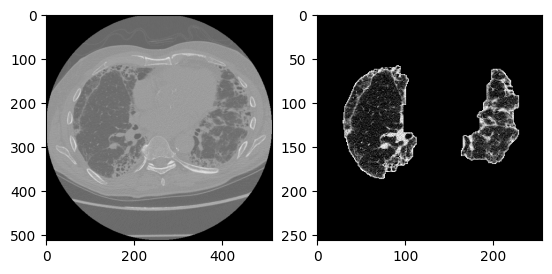

In [14]:
transform=transforms.Compose([
        CropBoundingBox(),
        ToHU(),
        Resize((30,256,256)),
        Clip(bounds=(-1000,200)),
        MaskWatershed(min_hu=min((-1000,200)), iterations=1, show_tqdm=True),
        Normalize(bounds=(-1000,200))
    ])
sample = {'image':image,'metadata':temp[0]}
plt.subplot(1,2,1)
plt.imshow(sample['image'][12],cmap='gray')
sample = transform(sample)
plt.subplot(1,2,2)
plt.imshow(sample['image'][12], cmap = 'gray')

In [ ]:
import imageio
imageio.mimsave("sample_input.gif", sample['image'], duration=0.0001)

In [23]:
class ToHU:
    def __call__(self,sample):
        image, metadata = sample['image'], sample['metadata']
        img_type = metadata.ImageType
        is_hu = img_type[0] == 'ORIGINAL' and not (img_type[2]=='LOCALIZER')
        intercept = metadata.RescaleIntercept
        slope = metadata.RescaleSlope
        image = (image*slope+intercept).astype(np.int16)
        return {'image':image,'metadata':metadata}
            

In [24]:
class CropBoundingBox:
    @staticmethod
    def bounding_box(img3d: np.array):
        mid_img = img3d[int(img3d.shape[0] / 2)]
        same_first_row = (mid_img[0, :] == mid_img[0, 0]).all()
        same_first_col = (mid_img[:, 0] == mid_img[0, 0]).all()
        if same_first_col and same_first_row:
            return True
        else:
            return False

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if not self.bounding_box(image):
            return sample

        mid_img = image[int(image.shape[0] / 2)]
        r_min, r_max = None, None
        c_min, c_max = None, None
        for row in range(mid_img.shape[0]):
            if not (mid_img[row, :] == mid_img[0, 0]).all() and r_min is None:
                r_min = row
            if (mid_img[row, :] == mid_img[0, 0]).all() and r_max is None \
                    and r_min is not None:
                r_max = row
                break

        for col in range(mid_img.shape[1]):
            if not (mid_img[:, col] == mid_img[0, 0]).all() and c_min is None:
                c_min = col
            if (mid_img[:, col] == mid_img[0, 0]).all() and c_max is None \
                    and c_min is not None:
                c_max = col
                break

        image = image[:, r_min:r_max, c_min:c_max]
        return {'image': image, 'metadata': data}

In [25]:
from scipy.ndimage import zoom

class Resize:
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        resize_factor = np.array(self.output_size) / np.array(image.shape)
        image = zoom(image, resize_factor, mode='nearest')
        return {'image': image, 'metadata': data}

class Clip:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image[image < self.min] = self.min
        image[image > self.max] = self.max
        return {'image': image, 'metadata': data}

class Normalize:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        image = image.astype(np.float)
        image = (image - self.min) / (self.max - self.min)
        return {'image': image, 'metadata': data}
    
class ToTensor:
    def __init__(self, add_channel=True):
        self.add_channel = add_channel

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']
        if self.add_channel:
            image = np.expand_dims(image, axis=0)

        return {'image': torch.from_numpy(image), 'metadata': data}
        
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, tensor):
        return tensor - self.pre_calculated_mean

In [26]:
class MaskWatershed:
    def __init__(self, min_hu, iterations, show_tqdm):
        self.min_hu = min_hu
        self.iterations = iterations
        self.show_tqdm = show_tqdm

    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        stack = []
        if self.show_tqdm:
            bar = trange(image.shape[0])
            bar.set_description(f'Masking CT scan {data.PatientID}')
        else:
            bar = range(image.shape[0])
        for slice_idx in bar:
            sliced = image[slice_idx]
            stack.append(self.seperate_lungs(sliced, self.min_hu,
                                             self.iterations))

        return {
            'image': np.stack(stack),
            'metadata': sample['metadata']
        }

    @staticmethod
    def seperate_lungs(image, min_hu, iterations):
        h, w = image.shape[0], image.shape[1]

        marker_internal, marker_external, marker_watershed = MaskWatershed.generate_markers(image)

        # Sobel-Gradient
        sobel_filtered_dx = ndimage.sobel(image, 1)
        sobel_filtered_dy = ndimage.sobel(image, 0)
        sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
        sobel_gradient *= 255.0 / np.max(sobel_gradient)

        watershed = segmentation.watershed(sobel_gradient, marker_watershed)

        outline = ndimage.morphological_gradient(watershed, size=(3,3))
        outline = outline.astype(bool)

        # Structuring element used for the filter
        blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                           [0, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [0, 1, 1, 1, 1, 1, 0],
                           [0, 0, 1, 1, 1, 0, 0]]

        blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)

        # Perform Black Top-hat filter
        outline += ndimage.black_tophat(outline, structure=blackhat_struct)

        lungfilter = np.bitwise_or(marker_internal, outline)
        lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)

        segmented = np.where(lungfilter == 1, image, min_hu * np.ones((h, w)))

        return segmented  #, lungfilter, outline, watershed, sobel_gradient

    @staticmethod
    def generate_markers(image, threshold=-400):
        h, w = image.shape[0], image.shape[1]

        marker_internal = image < threshold
        marker_internal = segmentation.clear_border(marker_internal)
        marker_internal_labels = measure.label(marker_internal)

        areas = [r.area for r in measure.regionprops(marker_internal_labels)]
        areas.sort()

        if len(areas) > 2:
            for region in measure.regionprops(marker_internal_labels):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        marker_internal_labels[coordinates[0], coordinates[1]] = 0

        marker_internal = marker_internal_labels > 0

        # Creation of the External Marker
        external_a = ndimage.binary_dilation(marker_internal, iterations=10)
        external_b = ndimage.binary_dilation(marker_internal, iterations=55)
        marker_external = external_b ^ external_a

        # Creation of the Watershed Marker
        marker_watershed = np.zeros((h, w), dtype=np.int)
        marker_watershed += marker_internal * 255
        marker_watershed += marker_external * 128

        return marker_internal, marker_external, marker_watershed

In [27]:
def show(list_imgs, cmap=cm.bone):
    list_slices = []
    for img3d in list_imgs:
        slc = int(img3d.shape[0] / 2)
        img = img3d[slc]
        list_slices.append(img)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, img in enumerate(list_slices):
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
        
    plt.show()

Masking CT scan ID00419637202311204720264:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_32/3529398283.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  marker_watershed = np.zeros((h, w), dtype=np.int)
/tmp/ipykernel_32/3529398283.py:58: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
Masking CT scan ID00419637202311204720264: 100%|██████████| 40

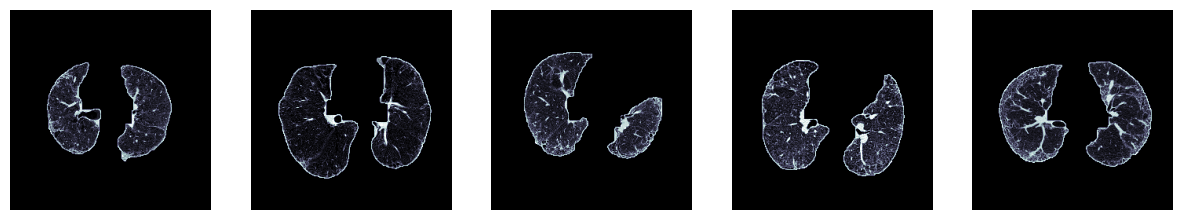

In [28]:

test = CTCDataset(
    root_dir='/kaggle/input/osic-pulmonary-fibrosis-progression/test',
    transform=transforms.Compose([
        CropBoundingBox(),
        ToHU(),
        Resize((40,256,256)),
        Clip(bounds=(-1000,200)),
        MaskWatershed(min_hu=min((-1000,200)), iterations=1, show_tqdm=True),
        Normalize(bounds=(-1000,200))
    ]))

list_imgs = [test[i]['image'] for i in range(len(test))]
show(list_imgs)

In [30]:
data = CTCDataset(
    root_dir=root_dir,
    transform=transforms.Compose([
        CropBoundingBox(),
        ToHU(),
        Resize((40,256,256)),
        Clip(bounds=(-1000,200)),
        MaskWatershed(
            min_hu=min((-1000,200)),
            iterations=1,
            show_tqdm=False),
        Normalize(bounds=(-1000,200)),
        ToTensor()
    ]))
#data.save(dest_dir)

In [31]:
class CTTensorsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.tensor_files = sorted([f for f in self.root_dir.glob('*.pt')])
        self.transform = transform

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()

        image = torch.load(self.tensor_files[item])
        if self.transform:
            image = self.transform(image)

        return {
            'patient_id': self.tensor_files[item].stem,
            'image': image
        }
    def mean(self):
        cum = 0
        for i in range(len(self)):
            sample = self[i]['image']
            cum += torch.mean(sample).item()

        return cum / len(self)

    def random_split(self, val_size: float):
        num_val = int(val_size * len(self))
        num_train = len(self) - num_val
        return random_split(self, [num_train, num_val])

In [37]:
pre_calculated_mean = 0.02865046213070556
latent_features = 10
batch_size = 16
learning_rate = 3e-5
num_epochs = 10
val_size = 0.2
tensorboard_dir = '/kaggle/working/runs'

In [53]:
train = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
cum = 0
for i in range(len(train)):
    sample = train[i]['image']
    cum += torch.mean(sample).item()

# assert cum / len(train) == pytest.approx(0)

In [54]:
cum

0

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
class AutoEncoder(nn.Module):
    def __init__(self, latent_features=latent_features):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.conv4 = nn.Conv3d(96, 1, 1)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.fc1 = nn.Linear(10 * 10, latent_features)
        # Decoder
        self.fc2 = nn.Linear(latent_features, 10 * 10)
        self.deconv0 = nn.ConvTranspose3d(1, 96, 1)
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool0 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)

        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)

        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        x = self.conv4(x)
        up0out_shape = x.shape
        x, i4 = self.pool4(x)

        x = x.view(-1, 10 * 10)
        x = F.relu(self.fc1(x))

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3, \
                   up0out_shape, i4

        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, \
        up1out_shape, i3, up0out_shape, i4 = self.encode(x)

        # Decoder
        x = F.relu(self.fc2(x))
        x = x.view(-1, 1, 1, 10, 10)
        x = self.unpool0(x, output_size=up0out_shape, indices=i4)
        x = self.deconv0(x)
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

In [47]:
t0 = time()

# Load the data
data = CTTensorsDataset(
    root_dir=root_dir,
    transform=ZeroCenter(pre_calculated_mean=pre_calculated_mean)
)
train_set, val_set = data.random_split(val_size)
datasets = {'train': train_set, 'val': val_set}
# dataloaders = {
#     x: DataLoader(
#         datasets[x],
#         batch_size=batch_size,
#         shuffle=(x == 'train'),
#         num_workers=2
#     ) for x in ['train', 'val']}

# dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# # Prepare for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = AutoEncoder(latent_features=latent_features).to(device)
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# best_model_wts = None
# best_loss = np.inf

# date_time = datetime.now().strftime("%Y%m%d-%H%M")
# log_dir = Path(tensorboard_dir) / f'{date_time}'
# writer = SummaryWriter(log_dir)

In [52]:
data

In [ ]:
# Training loop
for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_preds = 0

        # Iterate over data.
        bar = tqdm(dataloaders[phase])
        for inputs in bar:
            bar.set_description(f'Epoch {epoch + 1} {phase}'.ljust(20))
            inputs = inputs['image'].to(device, dtype=torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_preds += inputs.size(0)
            bar.set_postfix(loss=f'{running_loss / running_preds:0.6f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_file)

# load best model weights
model.load_state_dict(best_model_wts)

print(f'Done! Time {timedelta(seconds=time() - t0)}')